# A Deep Neural Network + Gaussian Process Regressor for Lung Volume

I am using a ConvNet in tandem with a Gaussian Process to regress 32 electrode readings into the expected lung volume measurement. Inputs are 32x224 matrices, corresponding to 32 electrodes, with 224 patterns. 

I also include occlusions and elevations as targets. 

In [1]:
%matplotlib inline

#Basic Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
!ls data8

normalized_plot.png  README.docx	test.csv   trainElev.csv  ypred.csv
range_-0dot5.png     rescaled_plot.png	train.csv  trainOccl.csv  ytest.csv


In [3]:
# Load Others
def load_data(path,test=False):
    if not test:
        dfile = path + '/train.csv'
        ofile = path + '/trainOccl.csv'
        efile = path + '/trainElev.csv'

        data   = pd.read_csv(dfile,header=None).values
        x_data = data[:,:-1].reshape((-1,32,224,1))
        y_data = data[:, -1]

        o_data = pd.read_csv(ofile,header=None).values
        e_data = pd.read_csv(efile,header=None).values
        return x_data,y_data,o_data,e_data
    
    else:
        tfile = path + '/test.csv'
        data   = pd.read_csv(tfile,header=None).values
        x_data = data[:,:-1].reshape((-1,32,224,1))
        y_data = data[:, -1]
        return x_data,y_data

In [4]:
# Load Data
path  = 'data8'
x_data,l_data,o_data,e_data=load_data(path)

In [5]:
# Scale Data
ysclr  = MinMaxScaler(feature_range=(0,0.5)).fit(l_data.reshape(-1,1))
y_data = ysclr.transform(l_data.reshape(-1,1)).squeeze()
o_data = o_data/100.
e_data = e_data.squeeze()

In [6]:
x_train,x_valid,\
y_train,y_valid,\
o_train,o_valid,\
e_train,e_valid = train_test_split(x_data,
                                   y_data,
                                   o_data,
                                   e_data,
                                   test_size=0.30,random_state=32)

## Regressor Model

In [7]:
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, AveragePooling2D, UpSampling2D
from keras.layers import Flatten, Reshape,Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import PReLU
from keras import regularizers
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

/home/junior/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
## Training Params
num_batch = 16
num_epoch = 30
patience  = 10

# Parameters
# ndim = x_train.shape[1]
npat,ndim,_ = x_train.shape[1:]
L1   = 127
L2   = 169
L3   = 16

In [9]:
# # Build DNN
# def build_model():
#     x = Input(shape=(npat,ndim,1),name='Input')
#     h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
#     h = BatchNormalization()(h)
#     h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
#     h = BatchNormalization()(h)
#     h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
#     h = BatchNormalization()(h)
#     h = AveragePooling2D((2,2),strides=(2,2))(h)
#     h = Flatten()(h)
    
    
#     # Lung Volume
#     y = Dense(7,activation='linear',name='L4')(h)
#     y = Dense(1,activation='linear',name='YOutput')(y)
#     ymodel = Model(x,y)
    
#     # Occlusion
#     o = Dense(10,activation='linear',name='O4')(h)
#     o = Dense(32,activation='relu',name='OOutput')(o)
    
#     # Elevation
#     e = Dense(5,activation='linear',name='E4')(h)
#     e = Dense(1, activation='linear',name='EOutput')(e)
#     cmodel = Model(inputs=[x],outputs=[y,o,e])
    
#     return ymodel, cmodel

In [10]:
# Build DNN
def build_model():
    x = Input(shape=(npat,ndim,1),name='Input')
    h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
    h = BatchNormalization()(h)
    h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
    h = BatchNormalization()(h)
    h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
    h = BatchNormalization()(h)
    h = AveragePooling2D((2,2),strides=(2,2))(h)
    h = Flatten()(h)
    h = Dense(7,activation='linear',name='L4')(h)
    y = Dense(1,activation='linear',name='Output')(h)
    model   = Model(x,y)
    encoder = Model(x,h) 
    return model, encoder

In [11]:
# # Compile Model
# model,cmodel = build_model()
# model.compile(optimizer='adam',loss='mean_squared_error')
# cmodel.compile(optimizer='adam', 
#                loss=['mean_squared_error','categorical_crossentropy','mean_squared_error'],
#                loss_weights=[0.7,0.15,0.15])
# model.summary()

In [12]:
# Compile Model
cnn_model,encoder = build_model()
encoder.compile(optimizer='adam', loss='mean_squared_error')

cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 224, 1)        0         
_________________________________________________________________
L1 (Conv2D)                  (None, 16, 75, 28)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 75, 28)        112       
_________________________________________________________________
L2 (Conv2D)                  (None, 8, 25, 16)         4048      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 25, 16)         64        
_________________________________________________________________
L3 (Conv2D)                  (None, 8, 9, 15)          2175      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 9, 15)          60        
__________

In [13]:
# Train
log = cnn_model.fit(x_train, y_train,
                batch_size=num_batch,
                epochs=num_epoch,
                shuffle=True,
                validation_data=(x_valid,y_valid))

Train on 53900 samples, validate on 23100 samples
Epoch 1/30
53900/53900 [==============================] - 34s 637us/step - loss: 0.0208 - val_loss: 0.0065
Epoch 2/30
53900/53900 [==============================] - 16s 306us/step - loss: 0.0049 - val_loss: 0.0032
Epoch 3/30
53900/53900 [==============================] - 17s 312us/step - loss: 0.0028 - val_loss: 0.0022
Epoch 4/30
53900/53900 [==============================] - 17s 311us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 5/30
53900/53900 [==============================] - 17s 319us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/30
53900/53900 [==============================] - 17s 321us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/30
53900/53900 [==============================] - 17s 317us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/30
53900/53900 [==============================] - 17s 321us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/30
53900/53900 [==============================] - 17s 309us/step - loss: 0.0011 - val_

In [14]:
# encoder.save('encoding_model.h5')
# model = load_model(modelname)

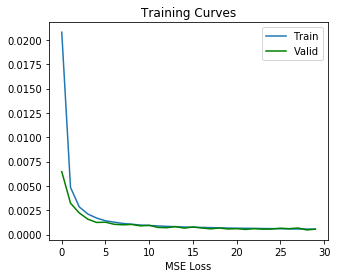

In [15]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.title('Training Curves')
# plt.ylim([0,0.05])
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid'])

In [16]:
# Generate Predictions for Test Set
x_test,y_test = load_data(path,test=True)
y_test = ysclr.transform(y_test.reshape(-1,1)).squeeze()
y_predict = cnn_model.predict(x_test)
loss = cnn_model.evaluate(x_test,y_test,verbose=0)

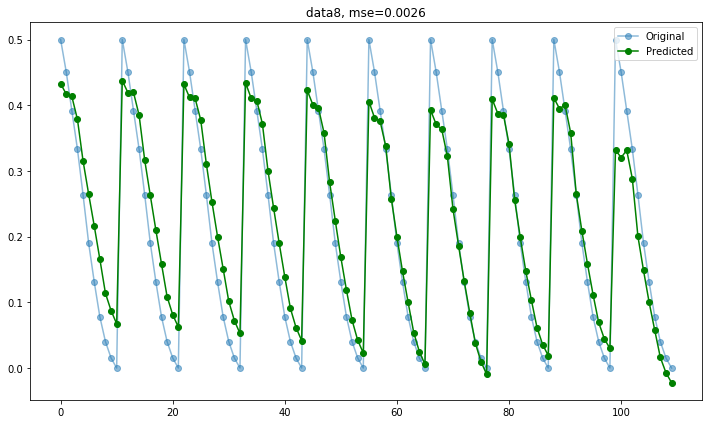

In [17]:
# Plot Results
plt.figure(figsize=(10,6))
plt.subplot(111)
plt.plot(y_test,'o-',alpha=0.5)
plt.plot(y_predict,'go-')
header = '{0}, mse={1:.04f}'.format(path,loss)
plt.title(header)

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

In [24]:
# Save Values
y_tst = ysclr.inverse_transform(y_test.reshape(-1,1)).squeeze()
y_prd = ysclr.inverse_transform(y_predict.reshape(-1,1)).squeeze()

oname = path + '/ypred.csv'
tname = path + '/ytest.csv'
np.savetxt(oname,y_predict,delimiter=',')
np.savetxt(tname,y_test,delimiter=',')

----

# Regression Models

In [ ]:
import xgboost as xgb

In [ ]:
# Get Encoded Training Data
xe_data = encoder.predict(x_data)
# e_vdata = encoder.predict(x_valid)

In [ ]:
l_data.shape

In [ ]:
xe_data.shape

In [ ]:
sindx = np.random.permutation(len(l_data))

In [ ]:
y_data.shape

In [ ]:
x_data.shape

In [ ]:
xgb_model = xgb.XGBRegressor(max_depth=10,learning_rate=0.01,n_estimators=350,silent=False,n_jobs=4)
xgb_model.fit(xe_data[sindx],l_data[sindx])

In [ ]:
## Test
xe_test = encoder.predict(x_test)
y_pred  = xgb_model.predict(xe_test)

In [ ]:
# Plot Results
plt.figure(figsize=(10,6))

plt.subplot(111)
plt.plot(y_test,'o-',alpha=0.5)
plt.plot(y_pred,'go-')
# header = '{0}, mse={1:.04f}'.format(path,loss)
# plt.title(header)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C

In [ ]:
e_tdata.shape

In [ ]:
kernel = C() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
gp = GaussianProcessRegressor(kernel=kernel,random_state=32,copy_X_train=False)
gp.fit(e_tdata,y_train)